# Harris Corner Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from scipy import ndimage as ndi
from scipy import signal as sig
from skimage import transform as tfm
from skimage import io
from skimage import util
from skimage import color

In [2]:
img = io.imread('original.jpg')
img = util.img_as_float(img)
img = color.rgb2gray(img)

## Gaussian Smooth

### Gaussian Kernel
1. Generate a 1D grid using `np.arange()` with the given size and expand into 2D using `np.meshgrid`.
2. For each element calculate Gaussian function with given sigma.
3. Because of normalization, the coefficient in the Gaussian function is omitted.

In [3]:
def gaussian_kernel(size, sigma):
    '''Returns a Gaussian kernel with specific size and sigma.'''
    
    # Generate grids of size 'size'
    shift = size // 2
    grid = np.arange(size) - shift
    x, y = np.meshgrid(grid, grid)

    # Coefficient 1 / (2 * np.pi ** 2) is omitted
    g = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    
    # Normalization
    g = g / g.sum()
    
    return g

### Smoothing
* Perform 2D convolution on the image using the kernel.

In [4]:
def gaussian_smooth(img, size, sigma):
    '''Performs Gaussian smooth on given image.'''
    
    # Get Gaussian kernel
    kernel = gaussian_kernel(size, sigma)

    # Perform 2D convolution
    output = ndi.convolve(img, kernel)

    return output

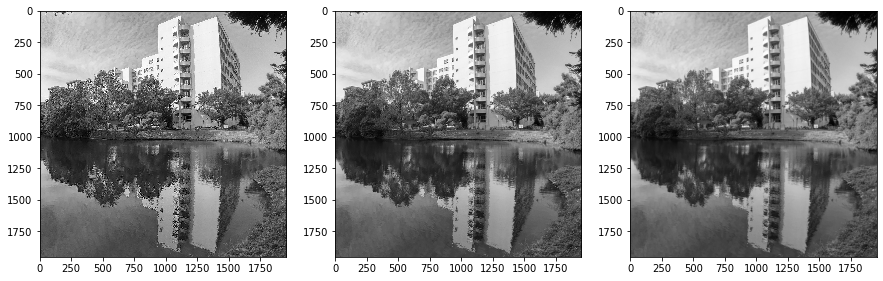

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

# Original
ax[0].imshow(img, cmap='gray')

# Gaussian smooth, kernel size = 5
gs_5 = gaussian_smooth(img, 5, 5)
ax[1].imshow(gs_5, cmap='gray')

# Gaussian smooth, kernel size = 10
gs_10 = gaussian_smooth(img, 10, 5)
ax[2].imshow(gs_10, cmap='gray')

plt.show()

## Sobel Edge Detection

### Sobel Operator
1. Initialize the kernels of datatype `np.float32`.
2. Perform 2D convolution on the given image using the two kernels.

In [6]:
def sobel_operator(img):
    '''Performs Sobel operator on given image and returns x and y component of gradients.'''
    # Initialize kernels
    kernel_x = np.float32([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]) / 8.0 
    kernel_y = np.float32([
        [-1, -2, -1], 
        [0, 0, 0], 
        [1, 2, 1]
    ]) / 8.0

    # Perform convolution
    gx = sig.convolve2d(img, kernel_x, mode='same')
    gy = sig.convolve2d(img, kernel_y, mode='same')
    
    return gx, gy

### Edge Detection
1. Perform Gaussian Smooth on the given image.
2. Calculate the gradient components for every pixel in the image.
3. Calculate the magnitude of the gradient of every pixel.
4. Calculate the direction of the gradient of every pixel. The result is shown by HSV.
    1. Set the hue as the gradient angle, which is calculated by `np.arctan2` then normalized.
    2. Set the saturation as maximum = 1.
    3. Set the value as the gradient magnitude, which is also normalized.
    4. Convert the result into a HSV image.

In [7]:
def sobel_edge_detection(img, size):
    '''Performs Sobel Edge detection and returns the magnitude and direction of gradients.'''
    # Gaussian Smooth
    image = gaussian_smooth(img, size, 5)
    
    # Sobel Operator
    gx, gy = sobel_operator(image)
    
    # Magnitude
    mag = np.sqrt(gx ** 2 + gy ** 2)

    # Direction
    m, n = image.shape
    hsv = np.zeros((m, n, 3))

    hsv[:,:,0] = (np.arctan2(gy, gx) + np.pi) / (2 * np.pi)  # Hue: Gradient angle
    hsv[:,:,1] = np.ones((m, n))                             # Saturation: Maximum, which is 1
    hsv[:,:,2] = (mag - mag.min()) / (mag.max() - mag.min()) # Value: Gradient magnitude
    dir_ = color.hsv2rgb(hsv)
    
    return [mag, dir_]

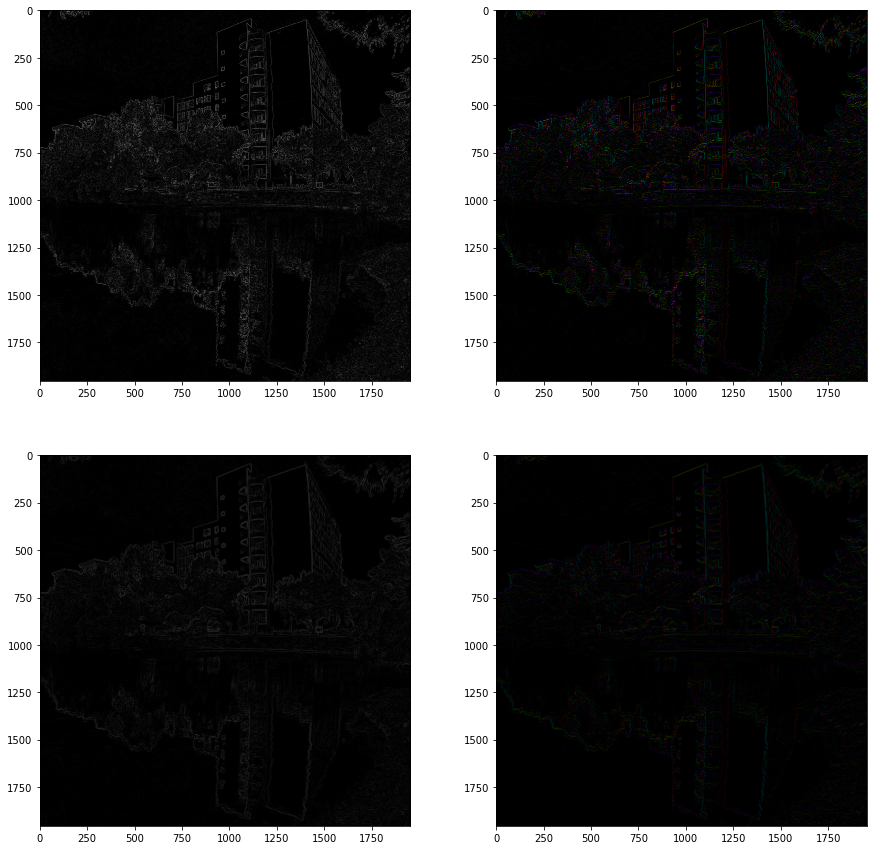

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# Sobel edge detection, kernel size = 5
sed = sobel_edge_detection(img, 5)
ax[0, 0].imshow(sed[0], cmap='gray')
ax[0, 1].imshow(sed[1])

# Sobel edge detection, kernel size = 10
sed = sobel_edge_detection(img, 10)
ax[1, 0].imshow(sed[0], cmap='gray')
ax[1, 1].imshow(sed[1])

plt.show()

## Structure Tensor
1. Perform Sobel operator to get the gradient components of each pixel.
2. Calculate \$I_{xx}, I_{yy}, I_{xy}$ by doing convolution with a window of Gaussian function, 
   which happens to be a Gaussian smooth.

In [9]:
def structure_tensor(img, size):
    '''Returns the structure tensor for the given image.'''
    # Sobel operator
    gx, gy = sobel_operator(img)

    # Compute structure tensor using Gaussian smooth
    Ixx = gaussian_smooth(gx * gx, size, 5)
    Iyy = gaussian_smooth(gy * gy, size, 5)
    Ixy = gaussian_smooth(gx * gy, size, 5)
    
    # Computer structure tensor with convolution: result not as good
    # window = np.ones((size, size))
    # Ixx = sig.convolve2d(gx * gx, window, mode='same')
    # Iyy = sig.convolve2d(gy * gy, window, mode='same')
    # Ixy = sig.convolve2d(gx * gy, window, mode='same')

    return Ixx, Iyy, Ixy

## Non-Maximum Suppression
1. Compute \$I_{xx}, I_{yy}, I_{xy}$ using `structure_tensor()` with the given image and size.
2. Calculate the determinant and the trace, which are then used to calculate the response function.
3. Set two masks:
    1. Threshold to suppress small values.
    2. Local maximum using `ndi.maximum_filter()`.
    3. Combine the two masks to find the wanted edges

In [10]:
def nms(img, size, ax):
    '''Performs Non-Maximum Suppression on the given image and returns an image with corners marked up.'''
    # Compute structure tensor
    Ixx, Iyy, Ixy = structure_tensor(img, size)

    # Compute response function
    det = Ixx * Iyy - Ixy ** 2
    trc = Ixx + Iyy
    kappa = 0.04

    R = det - kappa * trc * trc

    # Non-Maximum suppression
    threshold = (R > 5e-6)
    local_max = (np.abs(R - ndi.maximum_filter(R, size=30)) < 1e-14)
    mask = (threshold & local_max)

    r, c = np.nonzero(mask)

    # Plot figure
    ax.imshow(img, cmap='gray')
    ax.plot(c, r, 'r.', markersize=3)

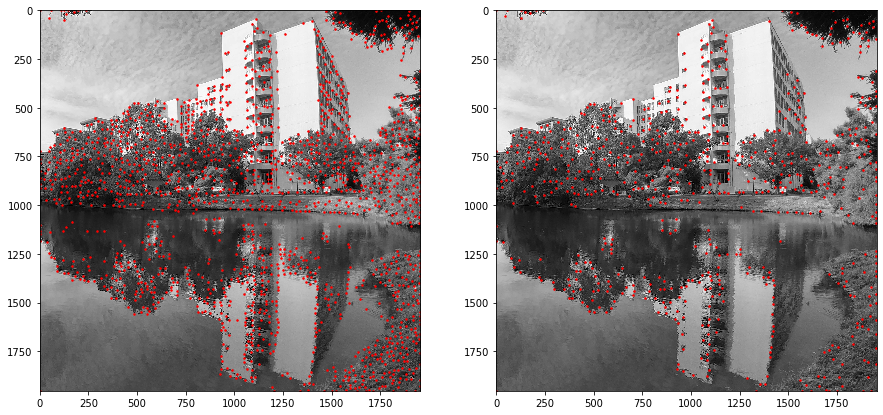

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Non-Maximum Suppression with window size = 3
nms(img, 3, ax[0])

# Non-Maximum Suppression with window size = 30
nms(img, 30, ax[1])

plt.show()

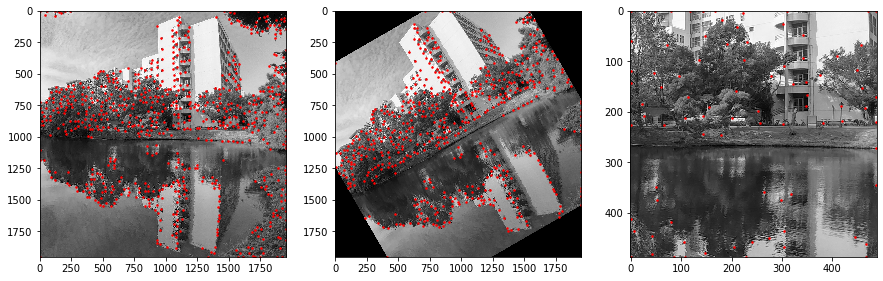

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

# Original image
nms(img, 30, ax[0])

# Rotated 30 degrees
nms(tfm.rotate(img, 30), 30, ax[1])

# Rescale by 0.5
rsc = tfm.rescale(img, 0.5, multichannel=False)

# Zoom in to part of the image
qm = rsc.shape[0] // 4
qn = rsc.shape[1] // 4

nms(rsc[qm:3 * qm, qn:3 * qn], 30, ax[2])

plt.show()